In [1]:
# @misc{towers_gymnasium_2023, 

#         title = {Gymnasium}, 

#         url = {https://zenodo.org/record/8127025}, 

#         abstract = {An API standard for single-agent reinforcement learning environments, with popular reference environments and related utilities (formerly Gym)}, 

#         urldate = {2023-07-08}, 

#         publisher = {Zenodo}, 

#         author = {Towers, Mark and Terry, Jordan K. and Kwiatkowski, Ariel and Balis, John U. and Cola, Gianluca de and Deleu, Tristan and Goulão, Manuel and Kallinteris, Andreas and KG, Arjun and Krimmel, Markus and Perez-Vicente, Rodrigo and Pierré, Andrea and Schulhoff, Sander and Tai, Jun Jet and Shen, Andrew Tan Jin and Younis, Omar G.}, 

#         month = mar, 

#         year = {2023}, 

#         doi = {10.5281/zenodo.8127026}, 

# } 

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas

class DataFrameTradingEnv(gym.Env):
    def __init__(self, df, render_mode=None, max_hold_steps = None, stop_loss = None, take_profit = None, see_position_value = False):
        super(DataFrameTradingEnv, self).__init__()
        self.df = df  # DataFrame with price data
        self.render_mode = render_mode
        self.max_hold_steps = max_hold_steps  # Maximum steps to hold a position. None means no forced selling.
        self.hold_duration = 0  # Track how long the current position has been held
        self.remaining_hold_steps = max_hold_steps

        self.stop_loss = stop_loss
        self.take_profit = take_profit


        self.curr_reward = 0
        self.reward = 0

        self.state = None  # To be initialized within reset()
        self.current_step = 1  
        self.position_open = False
        self.max_steps = len(df) - 1  # Set max_steps to the length of the DataFrame
        print("actual max length of game", self.max_steps)

        self.position_value = 0  # Initialize the position value

        self.see_pos_val_bool = see_position_value

        # Define action and observation space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        if self.see_pos_val_bool:
            self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # 0: open/hold, 1: close/do not open
        if self.max_hold_steps != None:
            self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

        if self.max_hold_steps != None and self.see_pos_val_bool:
            self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
            

        # Initialize lists to keep track of trades
        self.entry_points = []
        self.exit_points = []

    def update_state(self):
        # Pull the last 10 prices from the DataFrame
        price = self.df.iloc[self.current_step]
        prices = self.df.iloc[self.current_step-1:self.current_step+1]
        price_diff = prices.diff().dropna().values.flatten()
        prices = prices.values.flatten()
                # Update the position value and hold duration if a position is open
        if self.position_open:
            if self.max_hold_steps is not None:
                self.hold_duration += 1

            self.position_value = self.df.iloc[self.current_step] - self.entry_price
        # Append the current position value to the state
        # Calculate remaining hold steps and append to the state if max_hold_steps is specified
        # self.state = price
        self.state = price_diff
        # self.state = np.append(self.state, price_diff)
        # self.state = np.append(self.state, self.position_value/100)

        if self.max_hold_steps is not None:
            self.remaining_hold_steps = max(0, self.max_hold_steps - self.hold_duration)
            self.state = np.append(self.state, self.remaining_hold_steps/10)
            #self.state = np.append(self.state, self.current_step/100)ä

        if self.see_pos_val_bool:
            self.state = np.append(self.state, self.position_value)
            self.state = [0, self.position_value]

        return self.state

    def step(self, action):
        self.reward = 0
        #self.curr_reward = 0
        done = self.current_step >= self.max_steps - 1

        # Handle actions: open, hold, or close position
        if action == 0 and not self.position_open:  # Open a new position
            self.position_open = True

            self.entry_price = self.df.iloc[self.current_step]
            self.entry_points.append((self.current_step, self.entry_price))

        elif action == 1 and self.position_open:  # Close position
            self.close_position()

        # Force sell logic
        if self.position_open and self.max_hold_steps is not None:
            if self.remaining_hold_steps == 0:
                self.close_position()

        if self.position_open and self.take_profit is not None:
            if self.position_value >= self.take_profit:
                self.close_position()

        if self.position_open and self.stop_loss is not None:
            if self.position_value <= self.stop_loss:
                self.close_position()
            
        truncated = False  # or your logic to determine if the episode was truncated
        info = {'curr_reward': self.curr_reward}
        self.current_step += 1
        self.state = self.update_state() 
        return np.array(self.state), self.reward, done, truncated, info

    def close_position(self):

        # Logic to close the position
        self.curr_reward += (self.df.iloc[self.current_step] - self.entry_price)/100
        self.reward =(self.df.iloc[self.current_step] - self.entry_price)/100
        self.exit_points.append((self.current_step, self.df.iloc[self.current_step]))

        if self.max_hold_steps is not None:
            # reset holding time
            self.remaining_hold_steps = self.max_hold_steps
            self.hold_duration = 0

        self.position_open = False
        self.position_value = 0


    def reset(self, **kwargs):
        # Initialize state with the first 5 prices
        self.current_step = 1
        prices = self.df.iloc[self.current_step-1:self.current_step+1]
        price_diff = prices.diff().dropna().values.flatten()
        prices = prices.values.flatten()
        self.position_value = 0  # Reset the position value
        self.position_open = False
        self.hold_duration = 0
        self.entry_points = []
        self.exit_points = []
        self.curr_reward = 0
        self.reward = 0
        self.curr_reward = 0
        self.remaining_hold_steps == self.max_hold_steps
        self.state = self.update_state() 

        return np.array(self.state), {}

    def render(self, render_mode='human'):
    # Calculate total PnL
        total_pnl = 0
        cumulative_pnls = []
        if self.entry_points and self.exit_points:
            pnl_list = [exit_point[1] - entry_point[1] for entry_point, exit_point in zip(self.entry_points, self.exit_points)]
            total_pnl = sum(pnl_list)
            cumulative_pnls = [sum(pnl_list[:i+1]) for i in range(len(pnl_list))]

        # Create a figure and axis for the price plot
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot the price data
        ax1.plot(self.df.index, self.df, label='Price', color='blue')
        
        # In the render function:

        # Plot entry points as green dots on the price curve
        if self.entry_points:
            entry_x = [self.df.index[point[0]] for point in self.entry_points if point[0] < len(self.df.index)]
            entry_y = [self.df.iloc[point[0]] for point in self.entry_points if point[0] < len(self.df.index)]  # Use .iloc for accurate indexing
            ax1.plot(entry_x, entry_y, 'go', markersize=4, label='Entry')

        # Plot exit points as red dots on the price curve
        if self.exit_points:
            exit_x = [self.df.index[point[0]] for point in self.exit_points if point[0] < len(self.df.index)]
            exit_y = [self.df.iloc[point[0]] for point in self.exit_points if point[0]  < len(self.df.index)]  # Use .iloc for accurate indexing
            ax1.plot(exit_x, exit_y, 'ro', markersize=4, label='Exit')


       # Set titles and labels for the first axis
        ax1.set_title(f'Trading Visualization - Total PnL: ${total_pnl:.2f}')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params('y', colors='blue')
        ax1.legend(loc='best')

        # Create a second axis for the cumulative PnL
        ax2 = ax1.twinx()
        ax2.plot([self.df.index[point[0]] for point in self.exit_points if point[0] < len(self.df.index)], cumulative_pnls, label='Cumulative PnL', color='green', marker='o')
        ax2.set_ylabel('Cumulative PnL', color='green')
        ax2.tick_params('y', colors='green')
        ax2.legend(loc='upper left')

        # Display the plot
        plt.show()

In [2]:
random_prices = np.random.choice([0, 1], size=30)

# Creating a DataFrame with these random prices
binomial_noise_df = pd.DataFrame(random_prices, columns=['price'])

<Axes: >

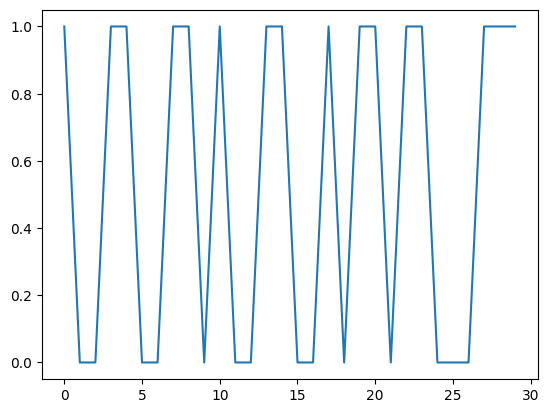

In [3]:
binomial_noise_df["price"].plot()

actual max length of game 29


Output()

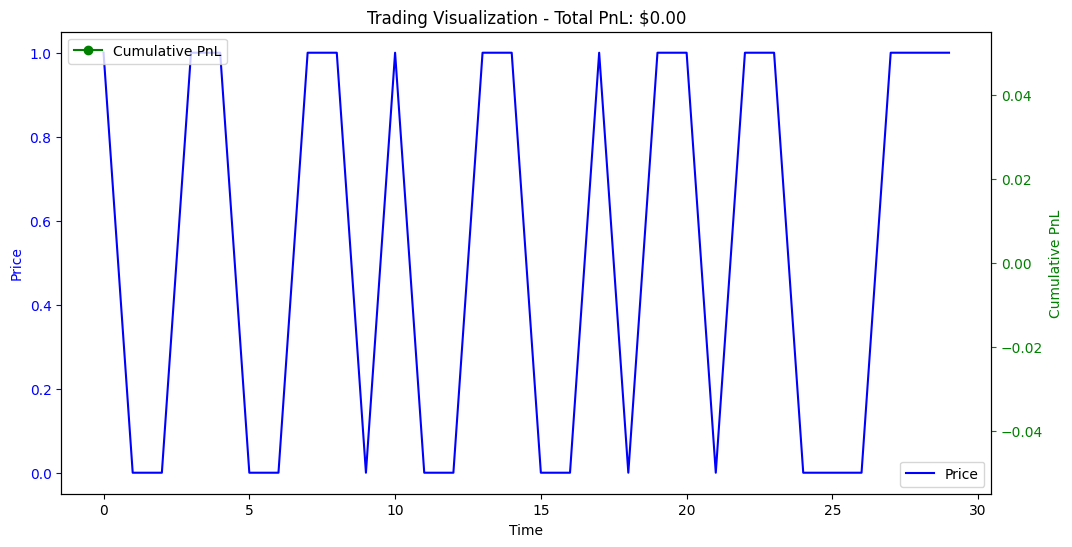

In [7]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecEnv
from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.env_util import make_vec_env

# Assuming that the SinusTradingEnv class is defined correctly

# Create and wrap the environment
env = DataFrameTradingEnv(binomial_noise_df["price"], render_mode='human', see_position_value=True)
#env = Monitor(env)  # Wrap with Monitor
env = DummyVecEnv([lambda: env])  # Wrap with DummyVecEnv
# env = VecNormalize(env)

# Create the PPO agent
model = PPO("MlpPolicy", env, verbose=0)#, policy_kwargs=dict(net_arch=[128, 128]))

# Now you can train the model
model.learn(total_timesteps=100_000, progress_bar=True)

# Render the environment
env.render()

# Close the environment
env.close()

In [8]:
random_prices = np.random.choice([0, 1], size=30)

# Creating a DataFrame with these random prices
test_binomial_prices = pd.DataFrame(random_prices, columns=['price'])

len of env 29
actual max length of game 29


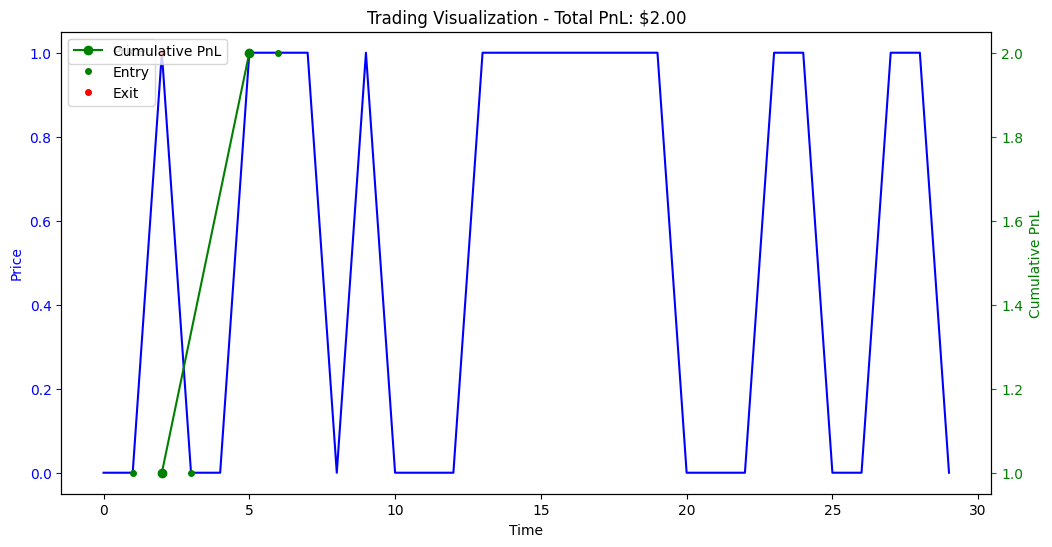

In [9]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecEnv
from stable_baselines3.common.monitor import Monitor

len_test_prices = len(test_binomial_prices)-1
print("len of env", len_test_prices)
# Create and wrap the environment
test_env = DataFrameTradingEnv(test_binomial_prices["price"], render_mode='human', max_hold_steps= None, see_position_value=True)
test_env = DummyVecEnv([lambda: test_env])  # Wrap with DummyVecEnv

obs = test_env.reset()
done = False
for i in range(len_test_prices):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = test_env.step(action)

    if i == 25:
        test_env.render()

# Close the environment
test_env.close()